In [1]:
import os
import sys

PATHNAME = "/content/drive/MyDrive"
if not os.path.exists(PATHNAME):
    PATHNAME = os.getcwd()

print(PATHNAME)
DATA_FOLDER = os.path.join(PATHNAME, "dataset")
OUTPUT_DIR = os.path.join(PATHNAME, "output")

/home/richard/play/IIITH/sem5/dip/project/DIP_Project


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

from IPython.display import Video

## Opening the Video file and Pre-processing

In [ ]:
def saveFramesToVideo(frames, savepath, fps=1):
  num_frames, H, W, C = frames.shape
  video = cv2.VideoWriter(savepath, 0, fps, (W, H))

  for frame in frames:
    video.write(frame)
  cv2.destroyAllWindows()
  print(f"Saving video to {savepath}")
  video.release()

Path of video file: /content/drive/MyDrive/dataset/bobble.mp4
(160, 480, 848)
Number of frames = 160


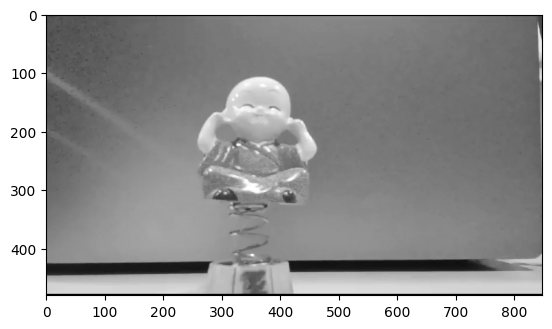

In [ ]:
video_file_name = "bobble.mp4"
video_path = os.path.join(DATA_FOLDER, video_file_name)

if os.path.exists(video_path):
    print(f"Path of video file: {video_path}")

# reading the video file
video_capture = cv2.VideoCapture(video_path)
num_frames = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
fps = video_capture.get(cv2.CAP_PROP_FPS)

frames = []
check = True
count = 0
initial_frame = None

while check:
    check, arr = video_capture.read()
    if arr is not None:
      if count == 0:
        initial_frame = np.copy(arr)
      arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
      frames.append(arr)
      count += 1

frames = np.array(frames)
print(frames.shape)
num_frames = frames.shape[0]
print(f"Number of frames = {num_frames}")

plt.imshow(frames[0], cmap='gray')


## Calculating Flow and Displacement of the entire video

In [ ]:
def calcVideoFlow(frames):
  """
  Calculates the flow of a video

  Input:
    - frames : grayscale image array of shape (num_frames, H, W)

  Output:
    - flows : flow array of shape (num_frames, H, W, 2)
  """
  num_frames = frames.shape[0]
  flows = []
  for i in range(1, num_frames):
    flow = cv2.calcOpticalFlowFarneback(
        frames[i - 1], frames[i], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flows.append(flow)

  flows = np.array(flows) # shape = (num_frames, H, W, 2)
  return flows

def convertFlowToRGB(flows):
  """
  converts the flow to RGB
  """
  num_frames, H, W, C = flows.shape
  hsv = np.zeros((num_frames, H, W, 3), dtype=np.uint8)
  flows_rgb = np.empty_like(hsv)
  hsv[:, :, :, 1] = 255 # setting the saturation to 255
  #hsv[:, :, :, 0] = 255

  for i in range(num_frames):
    # Set the hue and value according to the angle and magnitude
    magnitude, angle = cv2.cartToPolar(flows[i, :, :, 0], flows[i, :, :, 1])
    hsv[i, :, :, 0] = (angle * 180)/(2 * np.pi)
    hsv[i, :, :, 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    flows_rgb[i] = cv2.cvtColor(hsv[i], cv2.COLOR_HSV2BGR)

  return flows_rgb

def calcDispFromFlow(flows):
  """
  Get the displacement values from flow

  Input:
    - flows : array of shape (num_frames, H, W, 2) containing flow in x and y directions

  Output:
    - disp: array of shape (num_frames, H, W, 2) containing displacement in x and y directions
  """
  num_frames, H, W, _ = flows.shape
  disp = np.zeros((num_frames, H, W, 2), dtype=flows.dtype)
  disp[0] = flows[0]

  # adding flow values along x and y directions
  for i in range(1, num_frames):
    disp[i] += disp[i - 1] + flows[i]
  # disp[1:, :, :, 0] = np.cumsum(flows[:, :, :, 0], axis=-1)
  # disp[1:, :, :, 1] = np.cumsum(flows[:, :, :, 1], axis=-1)

  return disp

In [ ]:
# calculating the flow of every frame in the entire video
flows = calcVideoFlow(frames)
print(flows.shape)

(159, 480, 848, 2)


In [ ]:
# calculating the displacement from the flow values of the entire video
disp = calcDispFromFlow(flows) # (num_frames, H, W, 2)
print(disp.shape)

(159, 480, 848, 2)


In [ ]:
# converting the flow to RGB format for visualization purposes
flows_rgb = convertFlowToRGB(flows)
print(flows_rgb.shape)

(159, 480, 848, 3)


## Converting Flow to Flow RGB for visualization

In [ ]:
# convert the flow to RGB for visualization purposes
flows_rgb = convertFlowToRGB(flows)
print(flows_rgb.shape)

(159, 480, 848, 3)


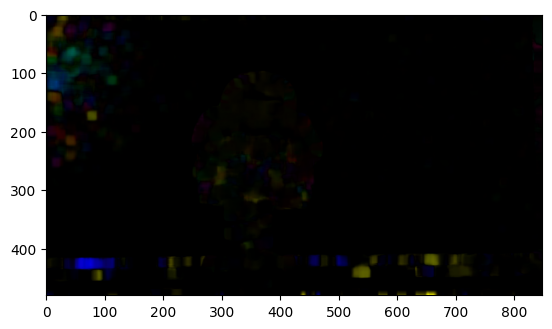

In [ ]:
plt.imshow(flows_rgb[0])

In [ ]:
# saving the flow rgb video
savepath = os.path.join(OUTPUT_DIR, "flow-rgb.avi")

saveFramesToVideo(flows_rgb, savepath, fps)

Saving video to /content/drive/MyDrive/dataset/flow-rgb.avi


In [ ]:
#Video(savepath, embed=True)

## Calculating FFT of displacement

In [ ]:
def calcPixelSpectrum(disp, pixel, axis=0):
  """
  Calculates the frequency spectrum of a pixel of a displacement values along an axis
  axis 0 = displacement in x direction
  axis 1 = displacement in y direction
  """
  num_frames, H, W, C = disp.shape
  i, j = pixel
  pixel_disp = disp[:, i, j, axis] # shape: (num_frames, )
  pixel_disp = pixel_disp - np.mean(pixel_disp)

  fft_result = np.fft.fft(pixel_disp)
  frequencies = np.fft.fftfreq(num_frames)
  magnitude = np.abs(fft_result)

  return frequencies, magnitude

Index of max frequency = 34, max frequency = 0.2138364779874214


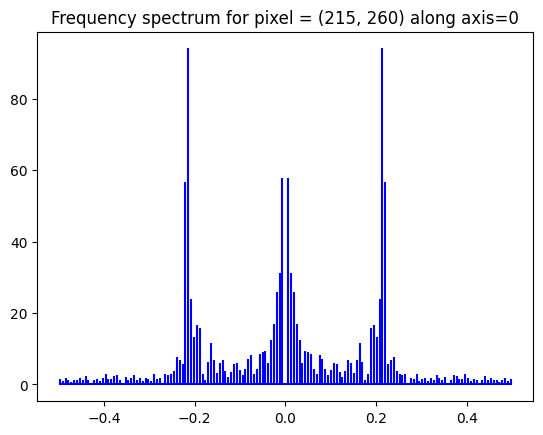

In [ ]:
# plotting the displacement frequency spectrum for a particular pixel in the image
pixel = (215, 260)
axis = 0
frequencies, magnitude = calcPixelSpectrum(disp, pixel, axis)

plt.stem(frequencies, magnitude, 'b', markerfmt=" ", basefmt="-b")
plt.title(f"Frequency spectrum for pixel = {pixel} along axis={axis}")

max_freq_index = np.argsort(magnitude)[::-1][0]
max_freq = frequencies[max_freq_index]
print(f"Index of max frequency = {max_freq_index}, max frequency = {max_freq}")
plt.show()


## Calculating Power Spectrum of image

In [ ]:
def calcPowerSpectrum(disp, axis=0):
  num_frames, H, W, C = disp.shape
  magnitude_sums = np.zeros(num_frames)

  fft_frequencies = np.fft.fftfreq(num_frames)
  values = disp[:, :, :, axis].reshape(num_frames, -1) # shape (num_frames, H*W)
  values = values - np.mean(values, axis=1, keepdims=True)
  fft_result = np.fft.fft(values, axis=0)

  mean_magnitudes = np.mean(np.abs(fft_result), axis=1)
  return fft_frequencies, mean_magnitudes

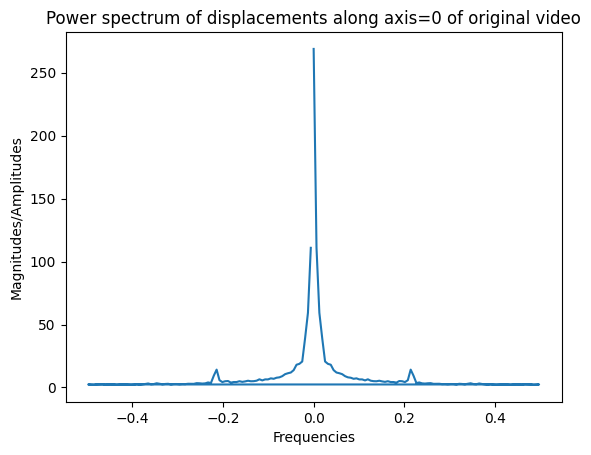

In [ ]:
axis = 0
fft_frequencies, mean_magnitudes = calcPowerSpectrum(disp, axis)

plt.title(f"Power spectrum of displacements along axis={axis} of original video")
plt.xlabel("Frequencies")
plt.ylabel("Magnitudes/Amplitudes")
plt.plot(fft_frequencies, mean_magnitudes)

plt.show()

## Showing Mode Shapes

In [27]:
def calcFreqShape(disp, axis=0, freq_index=0):
  """
  Calculating amplitude of a particular frequency of
  displacement in a set direction for all the pixels

  axis 0 = displacement in x direction
  axis 1 = displacement in y direction
  """
  num_frames, H, W, C = disp.shape

  fft_frequencies = np.fft.fftfreq(num_frames)
  values = disp[:, :, :, axis].reshape(num_frames, -1) # shape (num_frames, H*W)
  values = values - np.mean(values, axis=1, keepdims=True)
  fft_result = np.fft.fft(values, axis=0) # shape: (num_frames, H*W)

  magnitude, angle = np.abs(fft_result), np.angle(fft_result)
  magnitude = np.squeeze(magnitude[freq_index]).reshape(H, W)
  return magnitude

def calcModeShape(disp, axis=0, freq_index=0):
  num_frames, H, W, C = disp.shape
  mode_shape = np.zeros((H, W, 3), dtype=np.uint8)

  mode_shape[:, :, 0] = 255
  mode_shape[:, :, 1] = 255

  fft_frequencies = np.fft.fftfreq(num_frames)
  values = disp[:, :, :, axis].reshape(num_frames, -1) # shape (num_frames, H*W)
  values = values - np.mean(values, axis=1, keepdims=True)
  fft_result = np.fft.fft(values, axis=0) # shape: (num_frames, H*W)

  magnitude, angle = np.abs(fft_result), np.angle(fft_result)
  magnitude = magnitude.reshape(num_frames, H, W)
  angle = angle.reshape(num_frames, H, W)

  mode_shape[:, :, 0] = angle[freq_index]
  mode_shape[:, :, 2] = magnitude[freq_index]

  mode_shape[:, :, 2] = cv2.normalize(mode_shape[:, :, 2], None, 0, 255, cv2.NORM_MINMAX)
  mode_shape = cv2.cvtColor(mode_shape, cv2.COLOR_HSV2BGR)

  return mode_shape

In [ ]:
# calculating the mode shape
axis = 0
freq_index = max_freq_index
mode_shape = calcModeShape(disp, axis, freq_index)

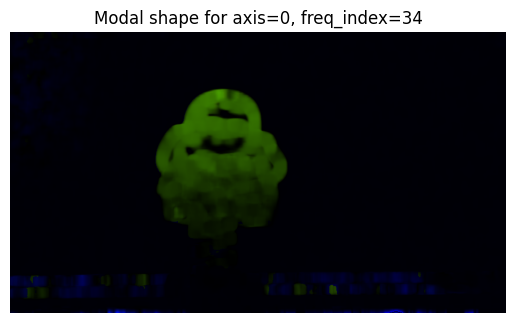

In [ ]:
# displaying the mode shape for a particular frequency
plt.title(f"Modal shape for axis={axis}, freq_index={freq_index}")
plt.axis("off")
plt.imshow(mode_shape)

plt.show()

## Implementing Physics of Modal analysis

In [ ]:
best_mode = calcFreqShape(disp, axis=0, freq_index=max_freq_index)
best_mode = best_mode.reshape(-1)
print(best_mode.shape)

(407040,)


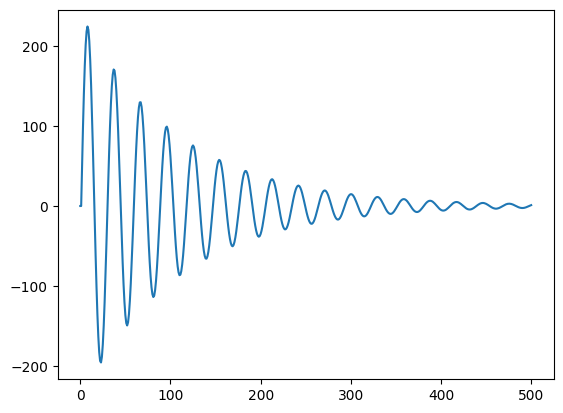

In [ ]:
a = 1
p = (215, 457) # point of application of force
d = [-1, 1] # x and y component
f_i = d[1] * np.abs(best_mode[p[0] * 848 + p[1]])
f = f_i

t = 500 # Number of time-steps to simulate vibration of
y = np.zeros((t + 1, 2))
h = 1 # we had assumed time stamp is 1 in the x+vt
d = 0.15
m = 1
w = 0.2138364779874214


m1 = np.array([[1, h], [-w**2 * h, 1 - 2*d*w*h]])
m2 = np.array([0, h/m])

for i in range(t):
  if(i != 0):
    f = 0
  y[i + 1] = (m1 @ y[i].T) + (m2.T * f)
  y[i + 1] = y[i + 1].T


plt.plot(y[:, 0])

### Finding Phi (modal matrix)

(500, 407040)


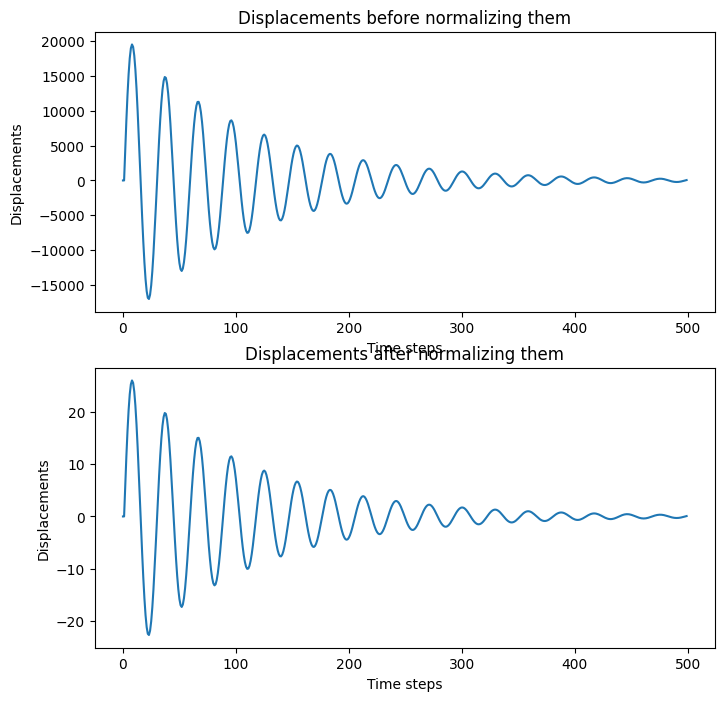

In [ ]:
num_frames, H, W = frames.shape
final_displacement = np.zeros((t, H * W))

for i in range(t):
  q = np.complex128(y[i][0] + (y[i][1] / w) * 1j)
  final_displacement[i, :] = (q * best_mode).real

print(final_displacement.shape)

# Plotting the final displacements of the pixel whose best mode was chosen
p2 = pixel
displacements = final_displacement[:, p2[0] * W + p2[1]]

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs = axs.flatten()

axs[0].set_title("Displacements before normalizing them")
axs[0].set_xlabel("Time steps")
axs[0].set_ylabel("Displacements")
axs[0].plot(displacements)

final_displacement = final_displacement / 750
displacements_norm = final_displacement[:, p2[0] * W + p2[1]]

axs[1].set_title("Displacements after normalizing them")
axs[1].set_xlabel("Time steps")
axs[1].set_ylabel("Displacements")
axs[1].plot(displacements_norm)

plt.show()

## Rendering the simulation

In [ ]:
# applying force along x direction
T = 500 # number of time-steps to simulate for
H, W, C = initial_frame.shape
final_displacement = final_displacement.reshape(-1, H, W) # (num_frames, H, W)
limit = W if dir == 1 else H # limit of the final destination

inpainting_mask = np.zeros((H, W), dtype=np.uint8)

# initialize the current frame with the initial frame
cur_frame = np.copy(initial_frame)
output_frames = []
output_frames.append(cur_frame)

grid = np.indices((H, W)) # shape = (2, H, W)

# Loop through each time-step/frame
for frame_idx in range(T):
  # calculating final destination of each pixel from the displacement values
  frame_flow_data = final_displacement[frame_idx] # shape = (H, W)
  final_destination = (grid[1] + frame_flow_data).astype(np.int64) # shape = (H, W)

  # indices of all valid new x positions
  indices = (0 <= final_destination) & (final_destination < limit)

  # apply optical flow for all the valid indices
  y, x = grid[0][indices], grid[1][indices]
  new_x = final_destination[indices]
  cur_frame[y, new_x] = initial_frame[y, x]

  # mark all the other pixels for inpainting
  inpainting_mask[grid[0][~indices], grid[1][~indices]] = 255 # set to white
  # performing inpainting on the current frame to fill gaps
  inpainting_radius = 5
  cur_frame = cv2.inpaint(cur_frame, inpainting_mask, inpainting_radius, cv2.INPAINT_TELEA)

  output_frames.append(cur_frame)

output_frames = np.array(output_frames)

In [ ]:
# saving the output frames
print(output_frames.shape)
savepath = os.path.join(OUTPUT_DIR, "output1.avi")

saveFramesToVideo(output_frames, savepath, fps)

(501, 480, 848, 3)
Saving video to /content/drive/MyDrive/dataset/output1.avi


#### Experimenting

In [ ]:
# applying force along x direction
T = 500 # number of time-steps to simulate for
H, W, C = initial_frame.shape
final_displacement = final_displacement.reshape(-1, H, W) # (num_frames, H, W)
limit = W if dir == 1 else H # limit of the final destination

inpainting_mask = np.zeros((T, H, W), dtype=np.uint8)

# initialize the current frame with the initial frame
frame_repeated = np.repeat(initial_frame[np.newaxis, :, :], T, axis=0) # shape (T, H, W)

output_frames = np.zeros((T + 1, H, W, C), dtype=initial_frame.dtype)
output_frames[0] = np.copy(initial_frame)

grid = np.indices((H, W)) # shape = (2, H, W)

y = np.repeat(grid[np.newaxis, :, :], T, axis=0) # shape (T, H, W)
x = np.repeat(grid[np.newaxis, :, :], T, axis=0) # shape (T, H, W)
final_destination = (x + final_displacement[:T]).astype(np.int64) # shape = (T, H, W)

# indices of all valid new x positions
indices = (0 <= final_destination) & (final_destination < limit) # shape (T, H, W)

# apply optical flow for all the valid indices
valid_y, valid_x = y[indices], x[indices] # shape (T, H, W)
new_x = final_destination[indices] # shape (T, H, W)
output_frames[1:, valid_y, new_x] = frame_repeated[valid_y, valid_x]

# mark all the invalid pixels for inpainting
inpainting_mask[~indices] = 255

# performing inpainint on all the frames to fill the gaps
inpainting_radius = 5
for frame_idx in range(1, T):
  output_frames[frame_idx] = cv2.inpaint(
      output_frames[frame_idx], inpainting_mask[indices],
      inpainting_radius, cv2.INPAINT_TELEA)

output_frames = np.array(output_frames)